In [59]:
from abc import ABC, abstractmethod
import numpy as np
import copy
import matplotlib.pyplot as plt
import networkx as nwx
import scipy.sparse as sparse

class Vertice:
    def __init__(self,idv:int,originalId:int,file,Vtype:str,movies=None):
        self.id=idv
        self.originalId=originalId
        self.degree=0
        self.Vtype=Vtype
        self.setPattern(file,movies)
        if self.Vtype=='movie':
            self.setTitle(file)
        
    def setPattern(self,file,movies):
        if self.Vtype=='user':
            if movies.any():
                self.q=[]
                genres=[genre.split('|') for genre in file[file['movieId'].isin(movies)]['genres']]
                for g in genres:
                    self.q+=g
                self.q=list(set(self.q))

            
        elif self.Vtype=='movie':
            self.q=[]
            genres=[genre.split('|') for genre in file[file['movieId'].isin([self.originalId])]['genres']]
            for g in genres:
                self.q+=g
            self.q=list(set(self.q))
            
        for i in range(len(self.q)):
            self.q[i]=self.q[i]+'_'+self.Vtype
    
    def setTitle(self,file):
         self.title=file[file['movieId'].isin([self.originalId])]['title'].mode()[0]
        
        

class Graph_bi:
    def __init__(self, V:list, I:list, edges):
        self.V=V #set of Vetices 
        self.I=I #set of labels constituing patterns
        self.edges=edges
        self.rowFormat = sparse.csr_matrix(self.edges)
        self.colFormat = sparse.csc_matrix(self.edges)
        self.q=[]
        self.setCorePattern()
        self.setDegrees()
        
    def setCorePattern(self):
        '''Calculate the core bi-pattern, i.e. the more specific patttern that occurs in the nodes.
        '''
        q1=self.I[0]
        q2=self.I[1]
        for v in self.V[0]:
            q1=[value for value in q1 if value in v.q]
        for v in self.V[1]:
            q2=[value for value in q2 if value in v.q]
        q=[q1,q2]
        self.q=q
        pass
    
    def setDegrees(self):
        '''Set the degree of each vertice, i.e. the number of connexion to the other vertices it has.
        '''
        self.minD=[self.rowFormat.indptr[self.V[0][0].id+1]-self.rowFormat.indptr[self.V[0][0].id],
                   self.colFormat.indptr[self.V[1][0].id+1]-self.colFormat.indptr[self.V[1][0].id]]
        for v in self.V[0]:
            v.degree=self.rowFormat.indptr[v.id+1]-self.rowFormat.indptr[v.id]
            if len(self.minD)==0:
                sel
            if (v.degree<self.minD[0]):
                self.minD[0]=v.degree
            
        for v in self.V[1]:
            v.degree=self.colFormat.indptr[v.id+1]-self.colFormat.indptr[v.id]
            if (v.degree<self.minD[1]):
                self.minD[1]=v.degree                
        pass
        
    def interior(self,h:int,a:int):
        '''Calculate the h-a BHA-core of the graphe. It remove the vertices from V1 (resp. V2) if its degree is less 
                than h (resp. a).
        '''
        self.setDegrees()
        c=0
        while (self.minD[0] < h)|(self.minD[1] < a):
            S1=[]
            S2=[]
            print("\n",c)
            
            for v in self.V[0]:
                if v.degree >= h:
                    S1.append(v)

                    
            for v in self.V[1]:
                print(v.degree >= a)
                if v.degree >= a:
                    S2.append(v)
            
            erows=[]
            ecols=[]
            edata=[]
            
            for v in S1:
                links=list(self.rowFormat.indices[self.rowFormat.indptr[v.id]:self.rowFormat.indptr[v.id+1]])
                graphv=[v.id for v in S2 if v.id in links]
                ecols+=graphv
                erows+=([v.id]*len(graphv))
                edata+=([1]*len(graphv))
                    
            c+=1
            print(len(erows))
            print(len(ecols))
            if (len(erows)==0)|(len(ecols)==0):
                return False
            
            self.edges=sparse.coo_matrix((edata, (erows, ecols)), shape=(int(max(erows))+1, int(max(ecols))+1))
            self.rowFormat = sparse.csr_matrix(self.edges)
            self.colFormat = sparse.csc_matrix(self.edges)
            self.V=[[v for v in S1 if v.id in list(set(erows))],[v for v in S2 if v.id in list(set(ecols))]]
            self.setDegrees()
    

        self.setCorePattern()
        return True         
    
    def extension(self,q):
        '''Calculate the support of q, i.e. the nodes which pattern contains q
        '''
        erows=[]
        ecols=[]
        edata=[]
        for v in self.V[0]:
            if ([value for value in q[0] if value in v.q]==q[0]):
                ecols+=list(self.rowFormat.indices[self.rowFormat.indptr[v.id]:self.rowFormat.indptr[v.id+1]])
                erows+=([v.id]*v.degree)
                edata+=([1]*v.degree)
        
        if (len(erows)==0)|(len(ecols)==0):
            return False
            
        V2=[v for v in self.V[1] if v.id in list(set(ecols))]
        edges= sparse.coo_matrix((edata, (erows, ecols)), shape=(int(max(erows))+1, int(max(ecols))+1))
        colFormat = sparse.csc_matrix(edges)        
        erows=[]
        ecols=[]
        edata=[]
            
        for v in V2:
            if ([value for value in q[1] if value in v.q]==q[1]):
                erows+=list(colFormat.indices[colFormat.indptr[v.id]:colFormat.indptr[v.id+1]])
                ecols+=([v.id]*(colFormat.indptr[v.id+1]-colFormat.indptr[v.id]))
                edata+=([1]*(colFormat.indptr[v.id+1]-colFormat.indptr[v.id]))
        
        if (len(erows)==0)|(len(ecols)==0):
            return False
            
        self.edges=sparse.coo_matrix((edata, (erows, ecols)), shape=(int(max(erows))+1, int(max(ecols))+1))
        self.rowFormat = sparse.csr_matrix(self.edges)
        self.colFormat = sparse.csc_matrix(self.edges)    
        self.V=[[v for v in self.V[0] if v.id in list(set(erows))],[v for v in V2 if v.id in list(set(ecols))]]
            
        self.setCorePattern()
        self.setDegrees()
        return True
    
    def minus(self,q:list):
        "Return the set of item from the alphabet I which is not in the pattern q"
        minus=[value for value in self.I[0]+self.I[1] if (value not in q[0]) & (value not in q[1])]
        return minus
    
    def add(self,q:list,x):
        "Return the pattern q with x added in the right place"
        q_new=copy.deepcopy(q)
        if x in self.I[0]:
            q_new[0] += [x]
        else:
            q_new[1] += [x]
            
        return q_new
    
    def Enumerate(self,EL:list,s:int,h:int,a:int):
        self.Output()
        for x in self.minus(self.q):
            p=self.add(self.q,x)
            Test=copy.deepcopy(self)
            is_connected=Test.extension(p)
            if is_connected:
                is_connected=Test.interior(h,a)
                if is_connected:
                    if (len(Test.V[0])>=s)&(len(Test.V[1])>=s):
                        if x not in EL:
                            self=copy.deepcopy(Test)
                            EL.append(x)
                            self.Enumerate(EL=EL,s=s,h=h,a=a)
            Test=None
                    


    def Output(self):
        #s=toStringPattern(self.q)
        print('Core pattern: ',self.q)
        G1 = nwx.Graph()
        nodelist=[]
        labels={}
        ids={}
        idx=0
        for v in self.V[0]:
            ids[str(v.id)+'V1']=idx
            G1.add_node(idx,bipartite=0)
            nodelist.append(idx)
            labels[idx]=str(v.id)
            idx+=1

        for v in self.V[1]:
            ids[str(v.id)+'V2']=idx
            G1.add_node(idx,bipartite=1)
            nodelist.append(idx)
            labels[idx]=v.title
            idx+=1
            

        for i in range(len(self.edges.row)):

            G1.add_edge(ids[str(self.edges.row[i])+'V1'],ids[str(self.edges.col[i])+'V2'])
    
        top_nodes = {n for n, d in G1.nodes(data=True) if d["bipartite"] == 0}
        bottom_nodes = set(G1) - top_nodes
        pos = nwx.bipartite_layout(G1,top_nodes)
        nwx.draw_networkx_nodes(G1,pos,nodelist=nodelist[:len(self.V[0])],node_color='c')
        nwx.draw_networkx_nodes(G1,pos,nodelist=nodelist[len(self.V[0]):],node_color='y')
        nwx.draw_networkx_edges(G1,pos)
        nwx.draw_networkx_labels(G1, pos, labels, font_size=12)

        plt.show() 
     

In [2]:
'''
Builds the graph quickly
'''
#%% Modules
#standard
from abc import ABC, abstractmethod
import time
import numpy as np
import numpy.random as rd
import scipy.sparse as sparse
import pandas as pd


#%% FastGraph class
class Graph:
    def __init__(self, userData = None, nChunk= 5, chunksize= int(1e6), path= None):
        '''
        Parameters
        --------
        size: str
            'small' (100K), 'heavy' (20M)
        '''
        # -- IO
        print('Graph init ...')
        if path != None:
            self.load_adjency(path)
        # -- Attributes
        if path == None:
            self.set_adjency(userData, nChunk= nChunk, chunksize= chunksize)

        self.rowFormat = sparse.csr_matrix(self.adjency)
        self.colFormat = sparse.csc_matrix(self.adjency)
        pass

    def get_user(self, userId: int):
        return self.rowFormat[userId]

    def get_movie(self, movieId: int):
        return self.colFormat[:,movieId]

    def load_adjency(self, path):
        try:
            self.adjency = sparse.load_npz(path)
            self.edges = self.adjency.data

        except FileNotFoundError:
            print("file was not found, please try again or provide userData")
            raise
        pass

    def save_adjency(self, fileName):
        sparse.save_npz(fileName, self.adjency)
        pass


    def set_adjency(self, userData, nChunk= np.inf, chunksize= int(1e6)):
        ''''''
        # -- Builds the matrix
        rows = []
        cols = []
        data = []
        for k,chunk in enumerate(userData):
            print('Processing chunk {}.'.format(k))
            for idx in range(len(chunk)):
                # -- keys : userId, movieId.
                row = chunk.iloc[idx]
                # -- getting ids
                userId, movieId= row['userId'], row['movieId']

                # -- updating rows, cols, data
                rows.append(userId)
                cols.append(movieId)
                data.append(k*chunksize+idx)

            #### temp ####
            if k == nChunk - 1:
                break

        adjency = sparse.coo_matrix((data, (rows, cols)), shape=(int(max(rows))+1, int(max(cols))+1))

        self.adjency = adjency
        self.edges = adjency.data
        pass

    def train_test_split(self, alpha: float):
        '''
        '''
        # -- Checking parameter alpha
        if alpha >= 1 or alpha <=0 or not(isinstance(alpha,float)):
            raise ValueError('alpha must be a float in ]0,1[')
        # -- Parameters
        edges = self.edges
        n = len(edges)
        nTest = int(alpha * n)
        indexes = list(range(n))

        # -- Randomizing data
        rd.shuffle(indexes)

        # -- Getting the split
        idxTrain, idxTest = sorted(indexes[nTest:]), sorted(indexes[:nTest])
        nTrain, nTest = len(idxTrain), len(idxTest)

        return edges[idxTrain], edges[idxTest]


class GraphExtract(Graph):
    def extract(self,UserId, MovieId, nbneighbors):
        
        moviesData=pd.read_csv('../../ml-latest/movies.csv')
        
        #Initialise the alphabets and the edges
        I1=[]
        I2=[]
        Erows=[]
        Ecols=[]
        Edata=[]
        
        #Setting the neighbors list
        users=list(self.colFormat.indices[self.colFormat.indptr[MovieId]:self.colFormat.indptr[MovieId+1]])
        movies=list(self.rowFormat.indices[self.rowFormat.indptr[UserId]:self.rowFormat.indptr[UserId+1]])
        
        users=users[:nbneighbors]
        movies=movies[:nbneighbors]
        
        users.append(UserId)
        movies.append(MovieId)
        
        users=list(set(users))
        movies=list(set(movies))

        #Setting Vertices
        UsersV=[]
        MoviesV=[]
        for i in range(len(users)):
            UsersV.append(Vertice(idv=i, originalId=users[i], file=moviesData, Vtype='user',
                                 movies=self.rowFormat.indices[self.rowFormat.indptr[users[i]]:self.rowFormat.indptr[users[i]+1]]))
        
        for i in range(len(movies)):
            MoviesV.append(Vertice(idv=i, originalId=movies[i], file=moviesData, Vtype='movie'))
            
          
        #Setting alphabet and edges
        for user in UsersV:
            usermv=list(self.rowFormat.indices[self.rowFormat.indptr[user.originalId]:self.rowFormat.indptr[user.originalId+1]])
            graphmv=[movie.id for movie in MoviesV if movie.originalId in usermv]
            Ecols+=graphmv
            Erows+=([user.id]*len(graphmv))
            Edata+=([1]*len(graphmv))
            I1+=user.q
        
        for movie in MoviesV:
            I2+=movie.q
            
        I1=list(set(I1))
        I2=list(set(I2))
        I=[I1,I2]
        Edges=sparse.coo_matrix((Edata, (Erows, Ecols)), shape=(int(max(Erows))+1, int(max(Ecols))+1))
        print(I)
        return Graph_bi(V=[UsersV,MoviesV],I=I,edges=Edges)


In [3]:
userMovieData_byChunk = pd.read_csv('../../userMovieData_small.csv', chunksize= int(1e6))
graph = GraphExtract(userMovieData_byChunk)

Graph init ...
Processing chunk 0.


In [60]:
g=graph.extract(4,899,7)

[['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', '(no genres listed)_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], ['Mystery_movie', 'Musical_movie', 'Romance_movie', 'Thriller_movie', 'Crime_movie', 'Sci-Fi_movie', 'Comedy_movie', 'Drama_movie']]


Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], []]


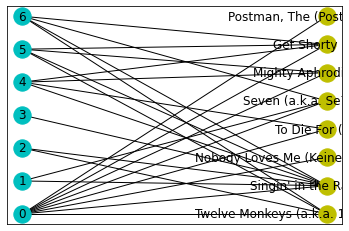

In [61]:
g.Output()

In [62]:
g.interior(2,2)

interior

[1, 1]

 0
V1 is part of the interior:  True
V1 id and degree:  0   8
V1 is part of the interior:  True
V1 id and degree:  1   2
V1 is part of the interior:  True
V1 id and degree:  2   2
V1 is part of the interior:  False
V1 is part of the interior:  True
V1 id and degree:  4   4
V1 is part of the interior:  True
V1 id and degree:  5   4
V1 is part of the interior:  True
V1 id and degree:  6   4
True
True
False
True
True
True
True
False
22
22
1
2
[2, 2]
22

V1id:  0
V1.degree:  6

V1id:  1
V1.degree:  2

V1id:  2
V1.degree:  2

V1id:  4
V1.degree:  4

V1id:  5
V1.degree:  4

V1id:  6
V1.degree:  4

V2id:  0
V2.degree:  4

V2id:  1
V2.degree:  6

V2id:  3
V2.degree:  2

V2id:  4
V2.degree:  3

V2id:  5
V2.degree:  3

V2id:  6
V2.degree:  4


True

Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], []]


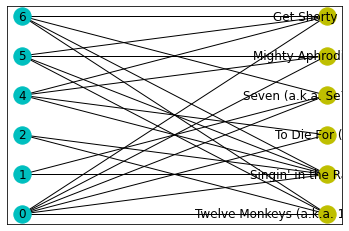

In [63]:
g.Output()

Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], []]


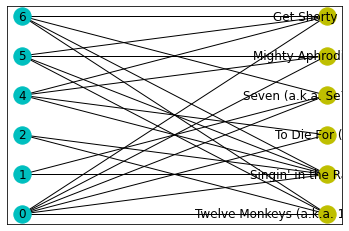


Processing interior
interior

[2, 1]

 0
V1 is part of the interior:  True
V1 id and degree:  2   2
False
False
0
0

Processing interior
interior

[1, 3]

 0
V1 is part of the interior:  True
V1 id and degree:  0   2
V1 is part of the interior:  False
V1 is part of the interior:  False
V1 is part of the interior:  False
V1 is part of the interior:  True
V1 id and degree:  6   2
True
True
4
4
3
0
[2, 2]
4

V1id:  0
V1.degree:  2

V1id:  6
V1.degree:  2

V2id:  0
V2.degree:  2

V2id:  4
V2.degree:  2

interior Test
Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], ['Mystery_movie', 'Thriller_movie']]


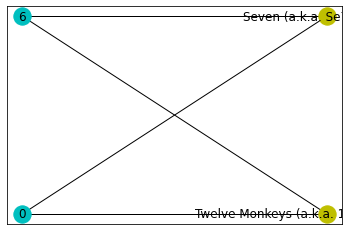

Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], ['Mystery_movie', 'Thriller_movie']]


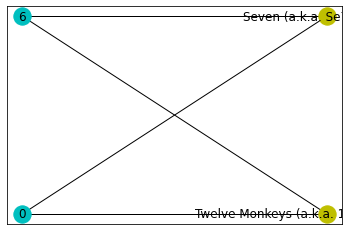


Processing interior
interior

[1, 2]

 0
V1 is part of the interior:  False
V1 is part of the interior:  False
True
0
0

Processing interior
interior

[2, 2]
[2, 2]
4

V1id:  0
V1.degree:  2

V1id:  6
V1.degree:  2

V2id:  0
V2.degree:  2

V2id:  4
V2.degree:  2

interior Test
Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], ['Mystery_movie', 'Thriller_movie']]


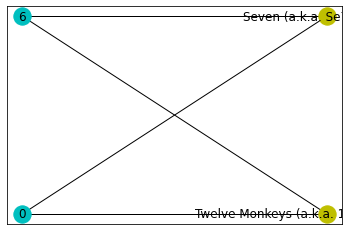

Core pattern:  [['Horror_user', 'IMAX_user', 'Adventure_user', 'Drama_user', 'Animation_user', 'Action_user', 'Crime_user', 'Sci-Fi_user', 'Musical_user', 'Fantasy_user', 'Mystery_user', 'Comedy_user', 'Film-Noir_user', 'War_user', 'Romance_user', 'Thriller_user', 'Documentary_user', 'Western_user', 'Children_user'], ['Mystery_movie', 'Thriller_movie']]


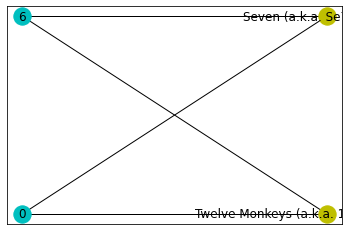


Processing interior
interior

[1, 2]

 0
V1 is part of the interior:  False
V1 is part of the interior:  False
True
0
0

Processing interior
interior

[1, 2]

 0
V1 is part of the interior:  False
V1 is part of the interior:  False
True
0
0


In [65]:
g.Enumerate(EL=[],s=1,h=2,a=2)

In [71]:
print(m['title'].mode()[0])

Toy Story (1995)


In [96]:
l=[1,2,4]
i=0
while i <len(l):
    print(i)
    if l[i]==2:
        l.pop(i)
    i+=1

print(l)

0
1
[1, 4]
